## A project for predicting turn direction from superior colliculus neural activity using a CNN
- The superior colliculus (SC) is a midbrain region that encodes turn direction. Can we predict turn direction from SC spiking activity using a convolutional neural network?
- Goal: By treating matrices of SC spiking data (neurons x time) as 'images' with labels of right or left turns, can we build a CNN to classify the images by turn direction? What might the model internals (filters) reveal about which neurons are predictive or non-predictive of turn direction?
- Data: Bilateral recording from mouse SC during a Y-maze navigation task (75 total neurons).

### Load and format data to Pytorch Dataset

In [1]:
import torch
import pickle
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# toggle to use GPU
use_gpu = 0

# set device
if torch.backends.mps.is_available() and use_gpu == 1:
    device = torch.device("mps")
    print("Using Apple GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using CPU


- Load trial data from example session, [trials x neurons x time] for right and left turns

In [2]:
# load SC data dict
data_tmp = pickle.load(open('/Users/cameronwilhite/Downloads/right_left_dict.pkl', 'rb'))
print('right turns: ' + str(np.shape(data_tmp['right'])))
print('left turns: ' + str(np.shape(data_tmp['left'])))

# reformat: label = 1 for right turn, 0 for left turn
labels = np.concatenate((
    np.ones(len(data_tmp['right']), dtype=np.int16),
    np.zeros(len(data_tmp['left']), dtype=np.int16)
))
activities = np.concatenate((data_tmp['right'], data_tmp['left']))
activities = np.expand_dims(activities, 1)  # add channel dimension

data = {
    'labels': labels,
    'activities': activities
}

right turns: (237, 75, 79)
left turns: (243, 75, 79)


- Next, plot example spiking data from a right turn trial and a left turn trial. These are two of the example 'images' we will be using to predict turn direction using the CNN.

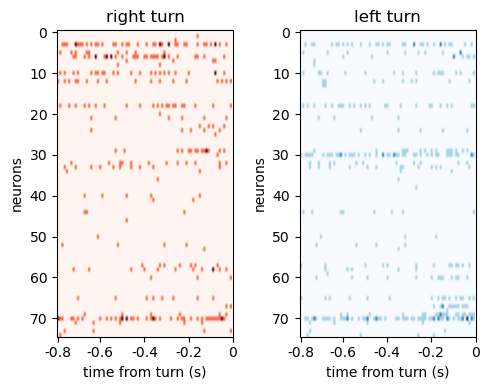

In [3]:
# plot example data
plt.figure(figsize=(5,4))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(data['activities'][103]), aspect='auto', cmap='Reds')
plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
plt.xlabel('time from turn (s)')
plt.ylabel('neurons')
plt.title('right turn')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(data['activities'][277]), aspect='auto', cmap='Blues')
plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
plt.xlabel('time from turn (s)')
plt.ylabel('neurons')
plt.title('left turn')

plt.tight_layout()

In [4]:
#create custom PyTorch dataset
class CustomDataset(Dataset):
      # - activity: [channels x neurons x time] array (treated like an image)
      # - label: 1 = right turn, 0 = left turn
    def __init__(self, data, transform=None, target_transform=None):
        self.labels = data['labels']
        self.activities = data['activities']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        activity = self.activities[idx]
        label = self.labels[idx]
        if self.transform:
            activity = self.transform(activity)
        if self.target_transform:
            label = self.target_transform(label)
        return activity, label
        
# initialize
dataset = CustomDataset(data)

### Functions for train-test split

In [5]:
from torch.utils.data import random_split, DataLoader

def train_test_split(dataset, train_ratio=0.8, batch_size=8):

    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        shuffle=False)
    return train_loader, test_loader

def train(model, 
          device, 
          train_loader, 
          optimizer,
          criterion,
          epoch,  # only needed for logging
          log_interval=10):
    
    model.train()  # sets the parameters to be trainable
    correct = 0

    for data, target in train_loader:

        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        
        optimizer.zero_grad()

        output = model(data)
        output = torch.squeeze(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pred = output > 0.5
        correct += pred.eq(target.view_as(pred)).sum().item()  # tally the number of correct
    
    return loss.item()
        
def test(model, 
         device,
         criterion,
         test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
            
            output = model(data)
            output = torch.squeeze(output)
            test_loss += criterion(output, target).item()  # sum the batch loss
            pred = output > 0.5
            correct += pred.eq(target.view_as(pred)).sum().item()  # tally the number of correct

    test_loss /= len(test_loader.dataset)

    return 100. * correct / len(test_loader.dataset)

### Build CNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import math

n_neurons = np.shape(data_tmp['right'])[1]
print(str(n_neurons) + ' neurons')

class CNN(nn.Module):
    def __init__(self, nbins=1, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=(n_neurons, nbins), stride=stride)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(1, 3), stride=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=(1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  # shape: [batch, 1, 1, time_reduced]
        x = torch.mean(x, dim=[2, 3])  # global average pooling
        return self.sigmoid(x)  # shape: [batch, 1]

75 neurons


### Run CNN
- Run model using 50 epochs and run this for 10 iterations of the model to look at the variability

In [7]:
criterion = nn.BCELoss()
epochs = 50
model_iters = 10 #(train-test splits)
test_score_models = {}

loss_all = []
test_scores = []

# for nbins in np.arange(1,11): # test different time bins

for nbins in [3]: # becomes stable with 3+ bins
    print('Training models with filter size ' + str(n_neurons) + 'x' + str(nbins))

    filters_all = []
    # how many iterations of the model to run
    for _ in range(0, model_iters):

        train_loader, test_loader = train_test_split(dataset)

        model = CNN(nbins=nbins)
        if use_gpu:
            model = model.to(device)

        loss_epoch = []
        lr = 0.01

        for idx, epoch in enumerate(range(epochs)):
            if idx % 10 == 0 and idx < 30:
                lr /= 10
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss = train(model, device, train_loader, optimizer, criterion, epoch)
            loss_epoch.append(loss)

        loss_all.append(loss_epoch)

        test_score = test(model, device, criterion, test_loader)
        test_scores.append(test_score)

        # extract filters for visualization
        filters = np.squeeze(model.conv1.weight.data.cpu().numpy())  # move to CPU and convert to numpy
        filters_all.append(filters)

print('Results:')
print('Mean test accuracy:' + str(np.mean(test_score)))
print('Std dev:' + str(np.std(test_scores)))
print('')

filters_all = np.array(filters_all)

Training models with filter size 75x3
Results:
Mean test accuracy:89.58333333333333
Std dev:1.381926995981418



### Interpret filters and relate back to neural activity
- One thing I was interested in was to see if the learned filters reflect neurons (rows) with consistently strong weights
- Let's first look at the first model iteration and each of the 8 filters in the first layer (conv1)

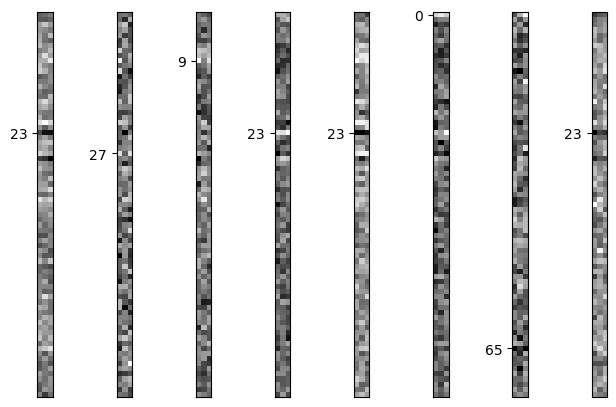

In [8]:
# visualize conv1 filters for first model iteration
filters_all = np.array(filters_all)
num_filters = filters_all.shape[1]

model_iter = 0

neuron_importance_per_filter = np.mean(np.abs(filters_all[model_iter]), axis=2)  # shape (8, n_neurons)
top_neurons_per_filt = np.array([np.argmax(neuron_importance_per_filter[i]) for i in range(0, np.shape(neuron_importance_per_filter)[0])])

fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 1, 5))
for i in range(num_filters):
    axs[i].imshow(filters_all[model_iter,i, :, :], cmap='gray')
    axs[i].set_yticks([top_neurons_per_filt[i]])
    axs[i].set_xticks([])

- It looks like neuron 23 in nearly all of the filters has a strong weight (defined as the average magnitude of the filter values across bins per row)
- Now, lets try this for all of the model iterations (still looking at conv1) to see if this is consistent. Next, let's compile all of the neuron hits with strong weights across iterations and plot their distribution.

neurons with consistently strong weights: [23 28]


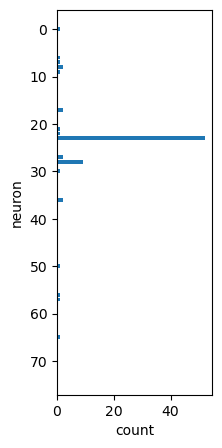

In [9]:
# find neurons that have consistently strong weights across all conv1 filters and model iterations
top_neurons_per_filt_all = []
for model_iter in range(0, model_iters):
    neuron_importance_per_filter = np.mean(np.abs(filters_all[model_iter]), axis=2)  # shape (8, n_neurons)
    
    top_neurons_per_filt = np.array([np.argmax(neuron_importance_per_filter[i]) for i in range(0, np.shape(neuron_importance_per_filter)[0])])
    top_neurons_per_filt_all.append(top_neurons_per_filt)
top_neurons_per_filt_all_concat = np.concatenate(np.array(top_neurons_per_filt_all))

plt.figure(figsize = (2,5))
counts, bins = np.histogram(top_neurons_per_filt_all_concat, bins=np.arange(0,np.shape(neuron_importance_per_filter)[1]))

plt.barh(bins[:-1], counts)
plt.xlabel('count')
plt.ylabel('neuron')
plt.gca().invert_yaxis()

#counts of neurons across filters and model iterations, take top 2
consistent_rows = np.argsort(counts)[::-1][0:2]
print('neurons with consistently strong weights: ' + str(consistent_rows))

- Again, neuron 23 has a lot of hits, also neuron 28. 
- Why might these neurons have consistent hits across model filters and iterations. Let's look at their activity relative to the turn (i.e., the input data) to see if it is predictive of turn direction.

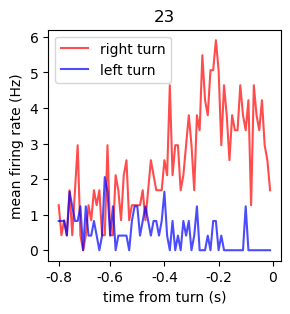

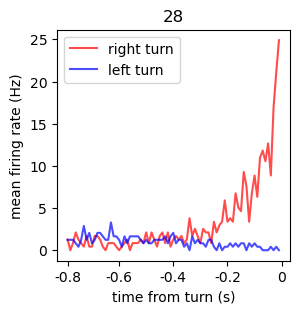

In [10]:
# examine mean firing rate for top consistent neurons between right and left turn trials
for row in consistent_rows:
    
    plt.figure(figsize = (3,3))
    plt.title(str(row), fontsize = 12)
    plt.plot(np.mean(data_tmp['right'][:,row,:], axis = 0), color = 'r', alpha = 0.7)
    plt.plot(np.mean(data_tmp['left'][:,row,:], axis = 0), color = 'b', alpha = 0.7)
    plt.ylabel('mean firing rate (Hz)')
    plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
    plt.xlabel('time from turn (s)')
    plt.legend(['right turn', 'left turn'])

- These SC neurons are turn-direction selective (i.e., their firing rates ramp up prior to the turn in one specific direction- left or right), so their spatio-temporal properties should be highly predictive of turn direction.
- Are these neurons actually special, or is it just their relationship to nearby neurons in the 'images' that results in their strong and consistent weights. How can we test this?
- Let's randomly permute the order of the input data (i.e., the arrangement of neurons) to see if this has an effect.

In [11]:
# reload SC data dict, permute the neuron dimension, and find neuron mapping
data_tmp = pickle.load(open('/Users/cameronwilhite/Downloads/right_left_dict.pkl', 'rb'))
print('right turns: ' + str(np.shape(data_tmp['right'])))
print('left turns: ' + str(np.shape(data_tmp['left'])))

arr1 = data_tmp['right']
arr2 = data_tmp['left']

# Fix the seed so shuffle is reproducible
np.random.seed(27) 

# permute neuron dimension
shuffle_idx = np.random.permutation(arr1.shape[1])
arr1_shuffled = arr1[:, shuffle_idx, :]
arr2_shuffled = arr2[:, shuffle_idx, :]
data_tmp['right'] = arr1_shuffled
data_tmp['left'] = arr2_shuffled

# find the neuron mapping after the permutation
inverse_shuffle = np.argsort(shuffle_idx) # indices that would sort thie shuffle array
mapped_indices = inverse_shuffle[consistent_rows]

print('neurons ' + str(consistent_rows) + ' are now neurons ' + str(np.where((shuffle_idx == 23) | (shuffle_idx == 28))[0]))

# reformat: label = 1 for right turn, 0 for left turn
labels = np.concatenate((
    np.ones(len(data_tmp['right']), dtype=np.int16),
    np.zeros(len(data_tmp['left']), dtype=np.int16)
))
activities = np.concatenate((data_tmp['right'], data_tmp['left']))
activities = np.expand_dims(activities, 1)  # add channel dimension

data = {
    'labels': labels,
    'activities': activities
}

right turns: (237, 75, 79)
left turns: (243, 75, 79)
neurons [23 28] are now neurons [10 33]


- To double check, let's make sure our example images look different:

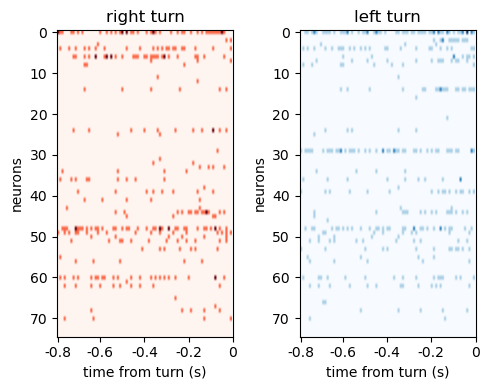

In [12]:
# plot example data
plt.figure(figsize=(5,4))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(data['activities'][103]), aspect='auto', cmap='Reds')
plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
plt.xlabel('time from turn (s)')
plt.ylabel('neurons')
plt.title('right turn')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(data['activities'][277]), aspect='auto', cmap='Blues')
plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
plt.xlabel('time from turn (s)')
plt.ylabel('neurons')
plt.title('left turn')

plt.tight_layout()

- Let's run the CNN again

In [13]:
# initialize
dataset = CustomDataset(data)

criterion = nn.BCELoss()
epochs = 50
model_iters = 10 #(train-test splits)

test_scores = []

# for nbins in np.arange(1,11): # test different time bins

for nbins in [3]: # becomes stable with 3+ bins
    print('Training models with filter size ' + str(n_neurons) + 'x' + str(nbins))

    filters_all = []
    # how many iterations of the model to run
    for _ in range(0, model_iters):

        train_loader, test_loader = train_test_split(dataset)

        model = CNN(nbins=nbins)
        if use_gpu:
            model = model.to(device)

        loss_epoch = []
        lr = 0.01

        for idx, epoch in enumerate(range(epochs)):
            if idx % 10 == 0 and idx < 30:
                lr /= 10
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss = train(model, device, train_loader, optimizer, criterion, epoch)
            loss_epoch.append(loss)

        loss_all.append(loss_epoch)

        test_score = test(model, device, criterion, test_loader)
        test_scores.append(test_score)

        # extract filters for visualization
        filters = np.squeeze(model.conv1.weight.data.cpu().numpy())  # move to CPU and convert to numpy
        filters_all.append(filters)

print('Results:')
print('Mean test accuracy:' + str(np.mean(test_score)))
print('Std dev:' + str(np.std(test_scores)))
print('')

filters_all = np.array(filters_all)

Training models with filter size 75x3
Results:
Mean test accuracy:91.66666666666667
Std dev:1.875



- Let's see if the new neuron hits match the old ones, or are differnt:

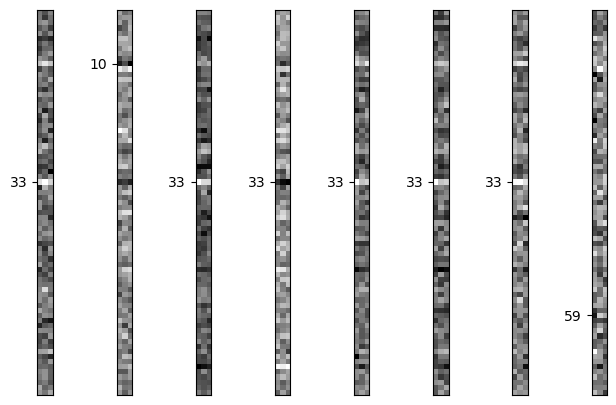

In [14]:
# visualize conv1 filters for first model iteration
filters_all = np.array(filters_all)
num_filters = filters_all.shape[1]

model_iter = 0

neuron_importance_per_filter = np.mean(np.abs(filters_all[model_iter]), axis=2)  # shape (8, n_neurons)
top_neurons_per_filt = np.array([np.argmax(neuron_importance_per_filter[i]) for i in range(0, np.shape(neuron_importance_per_filter)[0])])

fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 1, 5))
for i in range(num_filters):
    axs[i].imshow(filters_all[model_iter,i, :, :], cmap='gray')
    axs[i].set_yticks([top_neurons_per_filt[i]])
    axs[i].set_xticks([])

neurons with consistently strong weights: [33 10]


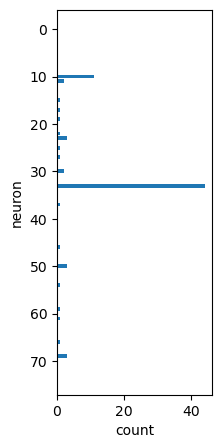

In [15]:
# find neurons that have consistently strong weights across all conv1 filters and model iterations
top_neurons_per_filt_all = []
for model_iter in range(0, model_iters):
    neuron_importance_per_filter = np.mean(np.abs(filters_all[model_iter]), axis=2)  # shape (8, n_neurons)
    
    top_neurons_per_filt = np.array([np.argmax(neuron_importance_per_filter[i]) for i in range(0, np.shape(neuron_importance_per_filter)[0])])
    top_neurons_per_filt_all.append(top_neurons_per_filt)
top_neurons_per_filt_all_concat = np.concatenate(np.array(top_neurons_per_filt_all))

plt.figure(figsize = (2,5))
counts, bins = np.histogram(top_neurons_per_filt_all_concat, bins=np.arange(0,np.shape(neuron_importance_per_filter)[1]))

plt.barh(bins[:-1], counts)
plt.xlabel('count')
plt.ylabel('neuron')
plt.gca().invert_yaxis()

#counts of neurons across filters and model iterations, take top 2
consistent_rows = np.argsort(counts)[::-1][0:2]
print('neurons with consistently strong weights: ' + str(consistent_rows))

- Again, the neurons that receive the most hits are the same ones from our orignal arragement of the data set.

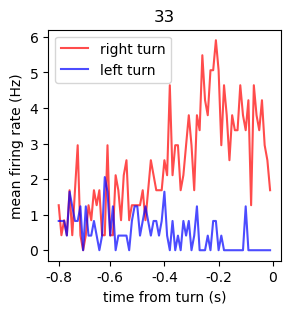

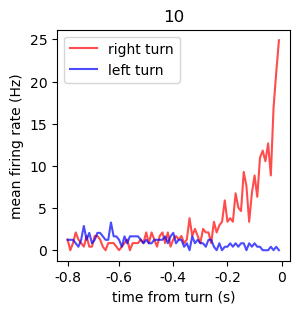

In [16]:
# examine mean firing rate for top consistent neurons between right and left turn trials
for row in consistent_rows:
    
    plt.figure(figsize = (3,3))
    plt.title(str(row), fontsize = 12)
    plt.plot(np.mean(data_tmp['right'][:,row,:], axis = 0), color = 'r', alpha = 0.7)
    plt.plot(np.mean(data_tmp['left'][:,row,:], axis = 0), color = 'b', alpha = 0.7)
    plt.ylabel('mean firing rate (Hz)')
    plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
    plt.xlabel('time from turn (s)')
    plt.legend(['right turn', 'left turn'])

- Can we do the opposite, see which neurons have the weakest weights across filters? What might the activity of the input data look like in this case?

neurons with consistently strong weights: [59 48]


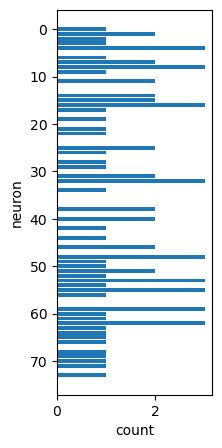

In [17]:
# find neurons that have consistently weak weights across all conv1 filters and model iterations
top_neurons_per_filt_all = []
for model_iter in range(0, model_iters):
    neuron_importance_per_filter = np.mean(np.abs(filters_all[model_iter]), axis=2)  # shape (8, n_neurons)
    
    top_neurons_per_filt = np.array([np.argmin(neuron_importance_per_filter[i]) for i in range(0, np.shape(neuron_importance_per_filter)[0])])
    top_neurons_per_filt_all.append(top_neurons_per_filt)
top_neurons_per_filt_all_concat = np.concatenate(np.array(top_neurons_per_filt_all))

plt.figure(figsize = (2,5))
counts, bins = np.histogram(top_neurons_per_filt_all_concat, bins=np.arange(0,np.shape(neuron_importance_per_filter)[1]))

plt.barh(bins[:-1], counts)
plt.xlabel('count')
plt.ylabel('neuron')
plt.gca().invert_yaxis()

#counts of neurons across filters and model iterations, take top 2
consistent_rows = np.argsort(counts)[::-1][0:2]
print('neurons with consistently strong weights: ' + str(consistent_rows))

- Finally, let's check how thee neurons behave in the training data:

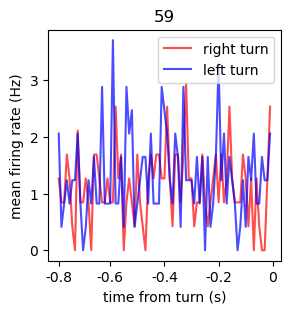

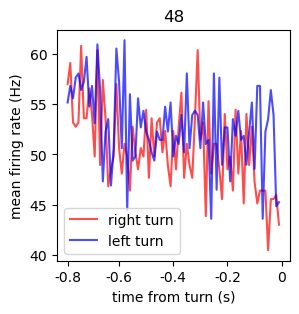

In [18]:
# examine mean firing rate for top consistent neurons between right and left turn trials
for row in consistent_rows:
    
    plt.figure(figsize = (3,3))
    plt.title(str(row), fontsize = 12)
    plt.plot(np.mean(data_tmp['right'][:,row,:], axis = 0), color = 'r', alpha = 0.7)
    plt.plot(np.mean(data_tmp['left'][:,row,:], axis = 0), color = 'b', alpha = 0.7)
    plt.ylabel('mean firing rate (Hz)')
    plt.xticks([0,19,39,59,79], labels = [-0.8, -0.6, -0.4, -0.2, 0])
    plt.xlabel('time from turn (s)')
    plt.legend(['right turn', 'left turn'])

- These neurons have weak turn-direction selectivity (no differences in firing rate during the time leading up to the turn), which matches our predictions.

### Conclusions
- Using a CNN, we can predict turn direction with ~90% accuracy from activity 'images' of superior colliculus spiking activity.
- There are certain neurons in the data that the model is using to consistently classify turn direction, and these neurons are indeed turn-direction selective. Conversely, neurons in the data that the model is not using to predict turn activity are weakly turn-direction selective.